In [2]:
import argparse
import os
from copy import deepcopy
from typing import Optional, Tuple

import gymnasium as gym
import numpy as np
import torch
from pettingzoo.classic import hanabi_v4
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import (
    BasePolicy,
    DQNPolicy,
    MultiAgentPolicyManager,
    RandomPolicy,
)
from tianshou.trainer import offpolicy_trainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [4]:
params = {
    'hidden_layers': [256,256],
    'gamma': 0.99,
    'lr': 1e-4,
    'target_update_freq': 100,
    'estimation_steps': 1,
    'num_train':50,
    'num_test':50,
    'buffer_size':50000,
    'batch_size':32,
    'steps_per_collect': 10000,
    'updates_per_train': 300,
    'test_steps': 50000,
    'epochs':1000,
    'test_frequency':5,
    'save_frequency':50
}

In [5]:
def get_env(render_mode=None):
    return PettingZooEnv(hanabi_v4.env(colors=1, ranks=5, players=2, hand_size=4, max_information_tokens=5,
max_life_tokens=2, observation_type=1))

In [3]:
def get_agents(
    lr = 1e-4, 
    hidden_layers = [256, 256], 
    gamma = 0.99,
    target_update_freq = 100, 
    estimation_steps = 1, 
    num_train = 50, 
    num_test = 50
):
    
    # Return Policy, Agents, Envs
    env = get_env()
    observation_space = env.observation_space['observation'] if isinstance(
    env.observation_space, gym.spaces.Dict
    ) else env.observation_space

    state_shape = observation_space.shape or observation_space.n
    action_shape = env.action_space.shape or env.action_space.n
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    net1 = Net(
            state_shape,
            action_shape,
            hidden_sizes=hidden_layers,
            device = device).to(device)

    net2 = Net(
        state_shape,
        action_shape,
        hidden_sizes=hidden_layers,
        device = device).to(device)

    optim1 = torch.optim.Adam(net1.parameters(), lr= lr)
    optim2 = torch.optim.Adam(net2.parameters(), lr = lr)

    agent1 = DQNPolicy(
            net1,
            optim1,
            gamma,
            estimation_steps,
            target_update_freq=target_update_freq
        )

    agent2 = DQNPolicy(
            net2,
            optim2,
            gamma,
            estimation_steps,
            target_update_freq=target_update_freq
    )

    agents = [agent1, agent2]
    policy = MultiAgentPolicyManager(agents, env)
    agents = env.agents

    train_envs = DummyVectorEnv([get_env for _ in range(num_train)])
    test_envs = DummyVectorEnv([get_env for _ in range(num_test)])
    
    return policy, agents, train_envs, test_envs

In [4]:
def get_collectors(
    policy,
    train_envs,
    test_envs,
    buffer_size
):
    
    # Get collectors
    train_collector = Collector(
    policy,
    train_envs,
    VectorReplayBuffer(buffer_size, len(train_envs)),
    exploration_noise=True)
    
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    
    return train_collector, test_collector

In [5]:
def initialize_buffer(
    train_collector,
    buffer_size,
    agents,
    policy,
    eps = 0.1
):
    for a in agents:
        policy.policies[a].set_eps(1)
    train_collector.collect(n_step = buffer_size)
    for a in agents:
        policy.policies[a].set_eps(eps)

In [44]:
def save_policy(policy, agents):
    for a in agents:
        torch.save(policy.policies[a].state_dict(), f'saved_data/training_group_1/{a}_params.pth')

def save_history(history):
    np.save(f'saved_data/training_group_1/training_rewards.npy', np.array(history))
    
def change_lr(optimizer, new_lr):
    # Run this to change the learning rate to 1e-5:
    for g in optimizer.param_groups:
        g['lr'] = new_lr

In [60]:
def train(
    policy,
    train_collector,
    test_collector,
    agents,
    epochs=1000,
    collection_steps_per_epoch=10000,
    updates_per_epoch=300,
    test_frequency=5,
    test_steps=50000,
    save_frequency = 50,
    batch_size = 32,
    eps = 0.1,
    training_history = []
):
    for i in tqdm(range(epochs)):
        
        # Collection step
        result = train_collector.collect(n_step = collection_steps_per_epoch)
        
        # Test Step
        if i%test_frequency == 0:
            for a in agents:
                policy.policies[a].set_eps(0)
            result = test_collector.collect(n_step = test_steps)
            mean_reward = result['rews'].mean()
            tqdm.write(str(mean_reward))
            training_history.append(mean_reward)
            for a in agents:
                policy.policies[a].set_eps(eps)
    
        if i%save_frequency == 0:
            save_policy(policy, agents)
            save_history(training_history)

        # Update step (one epoch)
        for _ in range(updates_per_epoch): losses = policy.update(batch_size, train_collector.buffer)
    
    plot_and_save(training_history, test_frequency)

In [62]:
def plot_and_save(training_history, test_frequency, save = True):
    x = np.arange(len(training_history))
    x *= test_frequency
    plt.plot(x, training_history)
    plt.title('Combined Average Score (2 player, 2 colors, 5 ranks)')
    plt.xlabel('Epoch')
    plt.ylabel('Average Score (max 10)')
    if save: plt.savefig(f'saved_data/training_group_1/training_curve.png')

In [ ]:
policy, agents, train_envs, test_envs = get_agents(lr = 1e-5)
train_collector, test_collector = get_collectors(policy, train_envs, test_envs, 50000)

In [57]:
for a in agents:
    policy.policies[a].load_state_dict(torch.load(f'saved_data/training_group_1/{a}_params.pth'))

In [64]:
training_history = list(np.load(f'saved_data/training_group_1/training_rewards.npy'))

In [59]:
train(policy, train_collector, test_collector, agents, updates_per_epoch = 500, training_history = training_history)

  0%|          | 0/1000 [00:00<?, ?it/s]

6.83489242282507
6.855632183908046
6.9500924214417745
6.886801099908341
6.845441925034706
6.859576427255985
6.884579870729455
6.897153351698806
6.881864328564836
6.889607390300231
6.943093162000918
6.9320165365181445
6.927322907083717
6.951724137931034
6.939880679210647
6.9386248269497
6.913143382352941
6.941095260009204
6.932537861404314
6.920569329660239
6.997717937015062
6.940421631530706
6.949261992619927
7.007826887661142
6.94268684089867
6.942439470077661
6.912844036697248
6.959743824336688
7.026146788990825
6.97157267308574
6.9475620975161
6.953605879650896
6.926402943882245
6.921739130434783
6.984410820724438
6.965201465201465
6.905330882352941
6.922191528545119
6.952860411899313
6.919577205882353
6.916016521340064
6.95970695970696
6.903863845446182
6.930574712643678
6.945412844036698
6.988532110091743
6.970224461749885
7.002294630564479
7.03391384051329
6.977064220183486
6.9359853680841335
7.002759889604416
6.9775846294602015
6.991762013729977
6.982142857142857
6.9067524115755

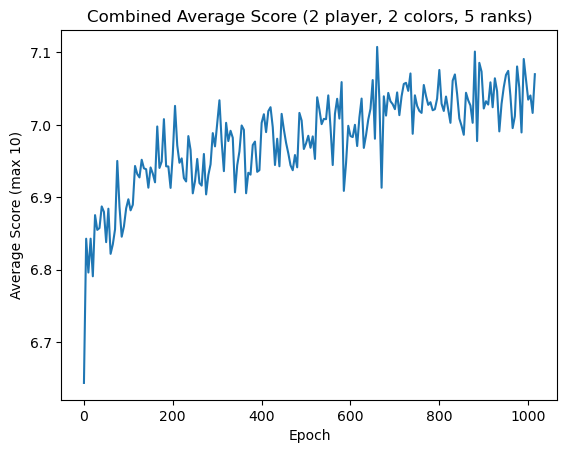

In [67]:
plot_and_save(training_history, 5)

In [6]:
get_env()

ValueError: Config parameter 1 is out of bounds. See description in hanabi.py.